In [1]:
### load libraries ###
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # data preprocessing, removing punctuation

import matplotlib.pyplot as plt # EDA, visualization
import seaborn as sns # EDA, visualization
from wordcloud import WordCloud # EDA, word cloud visualization

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # data preprocessing, matrix vectorization
from sklearn.decomposition import NMF # modeling, unsupervised classification
from sklearn.naive_bayes import MultinomialNB # modeling, classified model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # model evaluation

In [2]:
### import datasets ###

train_file = '/kaggle/input/bbc-news-classification/BBC News Train.csv'
test_file = '/kaggle/input/bbc-news-classification/BBC News Test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [3]:
# check data types
df_train.info()
df_test.info()

# show data frames
print(df_train.head(10))
print(df_test.head(10))

# understand category distribution
print(df_train['Category'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
   ArticleId                                               Text       Category
0       1833  worldcom ex-boss launches defence lawyers defe...       business
1        154  german business confidence slides german busin...       business
2       1101  bbc poll indicates economic gloom citizens in ...       business
3       1976  lifesty

In [4]:
print("-" * 50)
print("STEP 1: Problem & Data Description")
print("-" * 50)

--------------------------------------------------
STEP 1: Problem & Data Description
--------------------------------------------------


**Problem**: The original Kaggle competition task for this dataset was to employ both supervised and unsupervised classification methods to predict the category of an article based on its text. For my final assignments, I will:
* **Deep Learning**: Evaluate the performance of deep learning techniques, specifically LSTM and 1D CNN, on this dataset. Compare and discuss the deep learning technique performances against supervised and unsupervised techniques.

**Data Description**: Include are a testing dataset and a training dataset. The training dataset includes 1490 samples and the testing dataset includes 735 samples. The features included in these datasets are:
* **ArticleId**: int64, unique identifier for unique articles
* **Text**: string, article source text
* **Category**: object; classification of article; one of five: sport, business, politics, entertainment, tech (only in the training dataset, not the testing dataset)

In [5]:
print("-" * 50)
print("STEP 2a: EDA - Cleaning and Pre-processing")
print("-" * 50)

--------------------------------------------------
STEP 2a: EDA - Cleaning and Pre-processing
--------------------------------------------------


In [6]:
### Data Cleaning and Preprocessing: Lowercasing & Punctuation Removal ###
# For text vectorization, preprocessing should include setting all words in lowercase; removing punctuation; removing articles and prepositions ("stop words"); tokenization; and stemming.

# set words in lowercase
df_train['Text'] = df_train['Text'].str.lower()
df_test['Text'] = df_test['Text'].str.lower()

# remove punctation
def remove_punctuation(text):
    text = re.sub(r'a-z\s0-9\$', '', text) # retain a-z, 0-9, white spaces, and '$'
    return text

df_train['Text'] = df_train['Text'].apply(remove_punctuation)
df_test['Text'] = df_test['Text'].apply(remove_punctuation)

In [7]:
### Data Cleaning and Preprocessing: Stop Word Removal ###
# create function to remove stop words
# network issues when trying to download nltk stopwords, creating list
STOPWORDS = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 
    'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 
    'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 
    'weren', 'won', 'wouldn', 'sir', 'mr', 'said'
])

def remove_stopwords(text):
    words = text.split() # split text into individual words
    filtered_words = [word for word in words if word not in STOPWORDS] # filter out stop words
    return ' '.join(filtered_words)

# remove stop words
df_train['Text'] = df_train['Text'].apply(remove_stopwords)
df_test['Text'] = df_test['Text'].apply(remove_stopwords)

In [8]:
### Matrix Vectorization ###

# initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features = 5000)

# fit and transform the training data
X_train = vectorizer.fit_transform(df_train['Text'])

# transform test data
X_test = vectorizer.transform(df_test['Text'])

# print checks
print(X_train.shape)
print(X_test.shape)
print(vectorizer.max_features)

(1490, 5000)
(735, 5000)
5000


In [9]:
print("-" * 50)
print("STEP 2b: EDA - Visualization")
print("-" * 50)

--------------------------------------------------
STEP 2b: EDA - Visualization
--------------------------------------------------


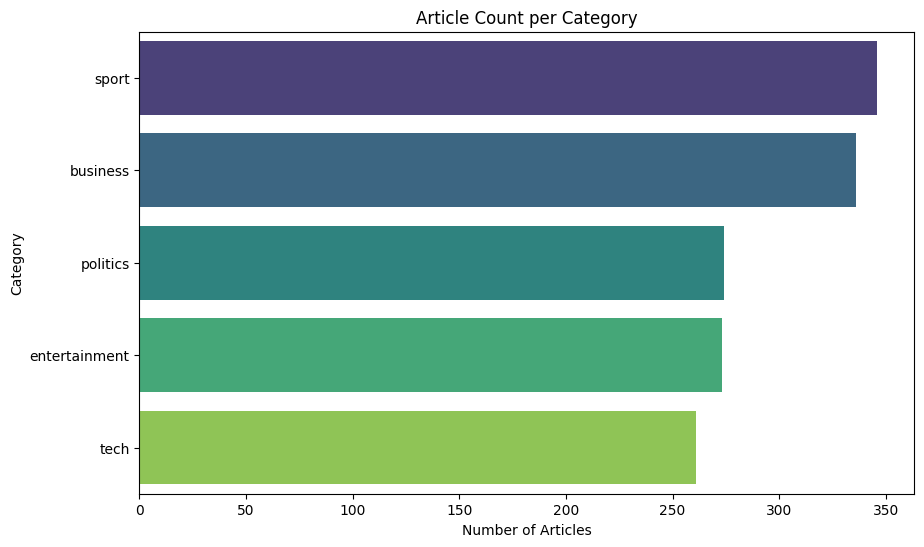


Category: BUSINESS
      word      count
0       us  11.166099
1     year   8.763084
2   growth   7.764591
3    sales   7.149070
4  economy   7.127741
5   market   6.627446
6     bank   6.557661
7     firm   6.437945
8      oil   6.303960
9      new   6.080677

Category: TECH
        word     count
0     people  9.199869
1     mobile  8.590518
2   software  6.209847
3      phone  6.134148
4  microsoft  5.882985
5      games  5.861652
6      music  5.824808
7        net  5.686138
8        new  5.598188
9      users  5.560890

Category: POLITICS
         word      count
0      labour  11.327022
1       would  10.509396
2    election  10.241838
3       blair  10.125145
4       brown   8.906876
5       party   8.788652
6  government   7.976292
7        said   7.275569
8      people   6.705527
9         tax   6.493539

Category: SPORT
      word      count
0  england  10.207931
1     game   8.428865
2    first   7.939599
3     year   7.855013
4    world   7.582149
5      win   7.176532
6  

In [10]:
### Exploratory Data Analysis ###
# EDA is used to understand key data characteristics: balance, sparsity, and feature correlation

# Check for balance between categories
plt.figure(figsize = (10, 6))
sns.countplot(y = 'Category',
             data = df_train,
             order = df_train['Category'].value_counts().index,
             palette = 'viridis')
plt.title("Article Count per Category")
plt.xlabel("Number of Articles")
plt.ylabel("Category")
plt.show()

# Show most common word in each category (n = 10)
def get_top_n_words(df, category, n = 10):
    category_text = df[df['Category'] == category]['Text'] # filter for specific category

    vectorize = CountVectorizer(max_features = 5000)
    X = vectorizer.fit_transform(category_text)

    word_counts = np.sum(X.toarray(), axis = 0)
    words_df = pd.DataFrame(
        {'word': vectorizer.get_feature_names_out(), 'count': word_counts}
    ).sort_values(by = 'count', ascending = False).reset_index(drop = True)

    return words_df.head(n)

categories = df_train['Category'].unique()

for category in categories:
    top_words = get_top_n_words(df_train, category, n = 10)
    print(f"\nCategory: {category.upper()}")
    print(top_words)

# sparsity check
sparsity = 1.0 - (X_train.nnz / (X_train.shape[0] * X_train.shape[1]))
print(f"\nSparsity of the TF-IDF Matrix: {sparsity:.4f}")

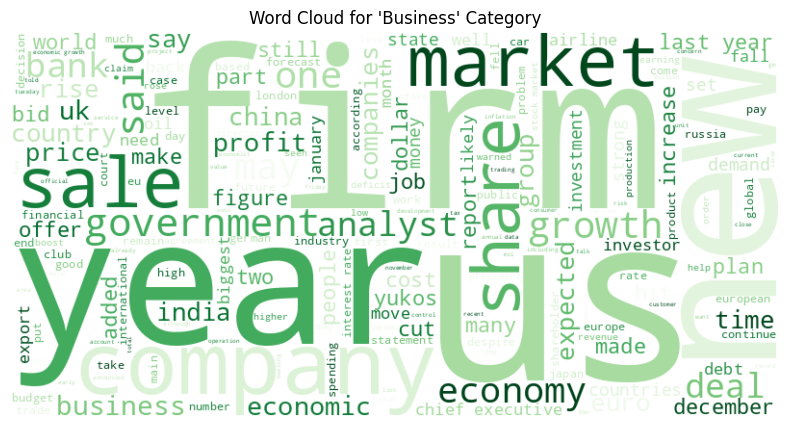

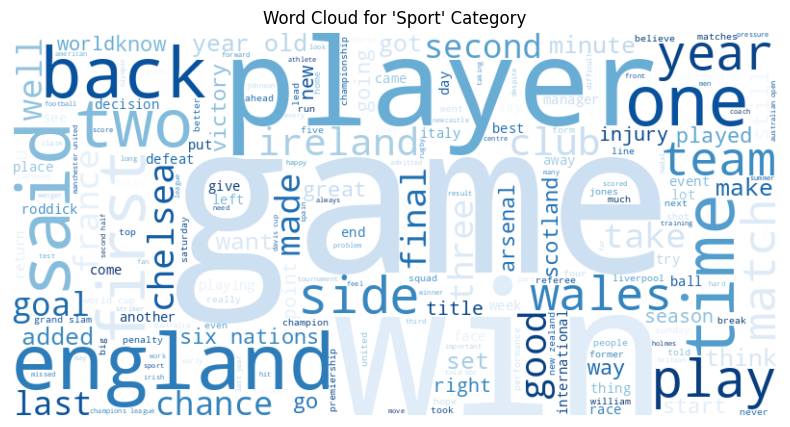

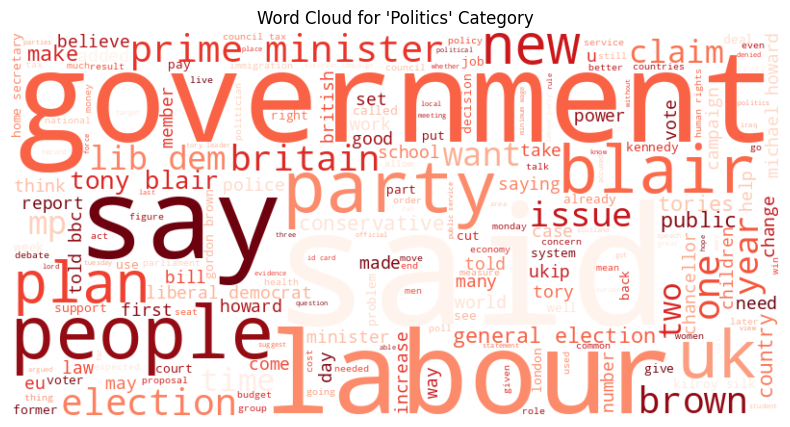

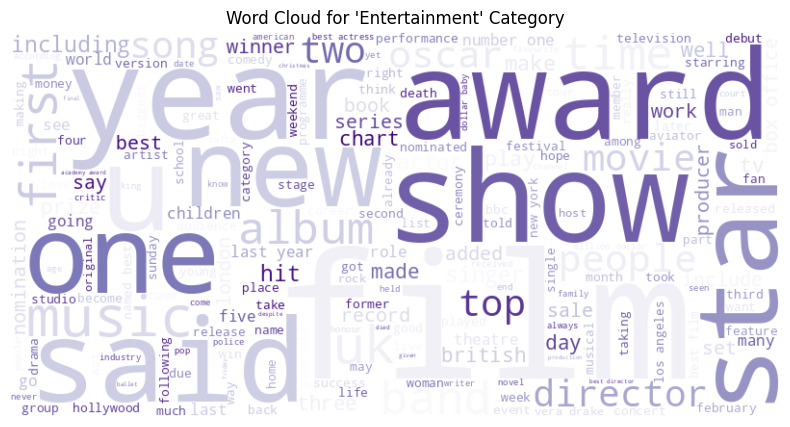

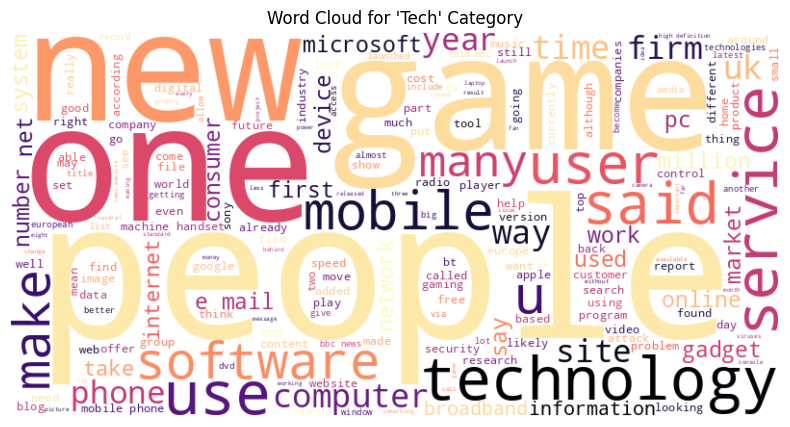

In [11]:
# word clouds (for funsies!)

# business
business_text = ' '.join(df_train[df_train['Category'] == 'business']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(business_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Business' Category")
plt.show()

# sport
sport_text = ' '.join(df_train[df_train['Category'] == 'sport']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(sport_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Sport' Category")
plt.show()

# politics
politics_text = ' '.join(df_train[df_train['Category'] == 'politics']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(politics_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Politics' Category")
plt.show()

# entertainment
entertainment_text = ' '.join(df_train[df_train['Category'] == 'entertainment']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Purples').generate(entertainment_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Entertainment' Category")
plt.show()

# tech
tech_text = ' '.join(df_train[df_train['Category'] == 'tech']['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(tech_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for 'Tech' Category")
plt.show()


In [19]:
print("-" * 50)
print("STEP 3: Model Building and Training")
print("-" * 50)

--------------------------------------------------
STEP 3: Model Building and Training
--------------------------------------------------


In [20]:
### Deep Learning: Data Preparation ###

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # To create a validation set

# define parameters
MAX_VOCAB = 10000  # Max number of unique words to keep in the vocabulary
MAX_LEN = 200      # Max sequence length (articles are typically short in this dataset)
EMBEDDING_DIM = 100 # Dimension for the word embedding vectors
RANDOM_STATE = 42

# encode labels
y = df_train['Category']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
NUM_CLASSES = len(le.classes_)

# tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<oov>")
tokenizer.fit_on_texts(df_train['Text'])

# convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(df_train['Text'])
test_sequences = tokenizer.texts_to_sequences(df_test['Text'])

# padding
X_train_dl = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_dl = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_dl, y_encoded, test_size=0.15, random_state=RANDOM_STATE, stratify=y_encoded
)

print(f"Vocabulary Size: {len(tokenizer.word_index)}")
print(f"Training Data Shape: {X_train_final.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test_dl.shape}")

Vocabulary Size: 24947
Training Data Shape: (1266, 200)
Validation Data Shape: (224, 200)
Test Data Shape: (735, 200)


In [21]:
### Deep Learning: Build and Train Model ###
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D

# build model
model = Sequential([
    # input layer
    Embedding(
        input_dim=MAX_VOCAB,          # Vocabulary size
        output_dim=EMBEDDING_DIM,     # 100-dimensional word vectors
        input_length=MAX_LEN          # 200 tokens long
    ),
    
    # core processing layer
    LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    
    # regularization (dropout)
    Dropout(0.5),
    
    # output Layer
    Dense(NUM_CLASSES, activation='softmax') # 5 classes, Softmax for multi-class probability
])

# compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Use for integer-encoded labels
    metrics=['accuracy']
)

model.summary()

# earlystopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.2476 - loss: 1.5759 - val_accuracy: 0.2143 - val_loss: 1.6745
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.3211 - loss: 1.5121 - val_accuracy: 0.4018 - val_loss: 1.1584
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.3948 - loss: 1.2147 - val_accuracy: 0.4152 - val_loss: 1.2228
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.4580 - loss: 1.1496 - val_accuracy: 0.4554 - val_loss: 1.2096
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.5410 - loss: 1.0626 - val_accuracy: 0.5134 - val_loss: 1.0465
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.5522 - loss: 1.0500 - val_accuracy: 0.5134 - val_loss: 1.1126
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.5895 - loss: 0.9861 - val_accuracy: 0.5670 - val_loss: 1.0121
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.6528 - loss: 0.8896 - val_accu

In [23]:
### Deep Learning: Evaluation ###
from sklearn.metrics import classification_report

# --- 3.1 Evaluate on Training Set ---
loss, dl_train_accuracy = model.evaluate(X_train_final, y_train_final, verbose=0)
print(f"LSTM Training Accuracy: {dl_train_accuracy:.4f}")

# --- 3.2 Generate Classification Report ---
y_train_pred_dl_proba = model.predict(X_train_final)
y_train_pred_dl = np.argmax(y_train_pred_dl_proba, axis=1)

# Decode labels for the report
target_names = le.classes_
print("\nLSTM Classification Report (Training Data):\n")
print(classification_report(y_train_final, y_train_pred_dl, target_names=target_names))

# --- 3.3 Final Comparison (Deep Learning vs. Traditional) ---
dl_accuracy = dl_train_accuracy

LSTM Training Accuracy: 0.8491
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

LSTM Classification Report (Training Data):

               precision    recall  f1-score   support

     business       0.95      0.93      0.94       285
entertainment       1.00      0.32      0.48       232
     politics       0.88      0.99      0.93       233
        sport       0.67      0.96      0.79       294
         tech       0.97      1.00      0.98       222

     accuracy                           0.85      1266
    macro avg       0.89      0.84      0.83      1266
 weighted avg       0.88      0.85      0.83      1266



In [33]:
### Deep Learning: Build 1D CNN Model ###
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# clear the previous model's session
tf.keras.backend.clear_session()

# define the CNN model
cnn_model = Sequential([
    # 1. embedding layer
    Embedding(
        input_dim=MAX_VOCAB,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN
    ),

    # 1D convolutional layer
    Conv1D(
        filters=32, # number of filters (feature detectors)
        kernel_size=2, # window size of 5 words (capturing 5-grams)
        activation='relu'
    ),

    # global max pooling
    GlobalMaxPooling1D(),
    
    # regularization (dropout)
    Dropout(0.8),

    # output layer
    Dense(NUM_CLASSES, activation='softmax')
])

# --- 2.2 Compile the Model ---
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
### Deep Learning: Train 1D CNN Model ###
early_stopping_cnn = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = cnn_model.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_cnn],
    verbose=1
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2104 - loss: 1.6520 - val_accuracy: 0.5312 - val_loss: 1.5336
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3173 - loss: 1.5213 - val_accuracy: 0.7500 - val_loss: 1.4141
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4134 - loss: 1.4110 - val_accuracy: 0.8259 - val_loss: 1.2577
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5236 - loss: 1.2642 - val_accuracy: 0.8750 - val_loss: 1.0760
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5595 - loss: 1.1311 - val_accuracy: 0.8839 - val_loss: 0.9282
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6264 - loss: 1.0378 - val_accuracy: 0.8973 - val_loss: 0.8004
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6439 - loss: 0.9487 - val_accuracy: 0.8973 - val_loss: 0.6969
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6889 - loss: 0.8535 - val_accuracy: 0.9062 - v

In [36]:
### Deep Learning: Evaluation ###
loss_cnn, dl_cnn_train_accuracy = cnn_model.evaluate(X_train_final, y_train_final, verbose=0)
print(f"1D CNN Training Accuracy: {dl_cnn_train_accuracy:.4f}")

# classification report
y_train_pred_cnn_proba = cnn_model.predict(X_train_final)
y_train_pred_cnn = np.argmax(y_train_pred_cnn_proba, axis=1)

print("\n1D CNN Classification Report (Training Data):\n")
print(classification_report(y_train_final, y_train_pred_cnn, target_names=target_names))

1D CNN Training Accuracy: 0.9921
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

1D CNN Classification Report (Training Data):

               precision    recall  f1-score   support

     business       0.99      0.98      0.99       285
entertainment       1.00      1.00      1.00       232
     politics       1.00      0.99      0.99       233
        sport       1.00      1.00      1.00       294
         tech       0.98      1.00      0.99       222

     accuracy                           0.99      1266
    macro avg       0.99      0.99      0.99      1266
 weighted avg       0.99      0.99      0.99      1266



In [37]:
print("-" * 50)
print("STEP 4: Results and Discussion")
print("-" * 50)

--------------------------------------------------
STEP 4: Results and Discussion
--------------------------------------------------


### Model Accuracy Results
**Deep Learning**
* **LSTM**: 0.8491
* **1D CNN**: 0.9921

**Unsupervised Machine Learning**
* **Optimized Non-negative Matrix Factorization**: 0.9255

**Supervised Machine Learning**
* **Multinomial Bayes**: 0.9919

### Discussion
* **Traditional Models Excelled** The high accuracy of traditional models suggests that the article categories are highly linearly separable. Additionally, the TD-IDF approach effectively identified highly differentiating words. These traditional models are also less prone to overfitting, especially compare to the deep learning models.
* **Deep Learning Models Underperformed** Both deep learning models likely overfit to noise. Word embeddings are beter for implicit and dense data; but, since this dataset is explicit and sparse, TD-IDF is much better than embedding.